# Glauber dynamics of the Random Field Ising model 

Compare with results in [Vázquez, Eduardo Domínguez, Gino Del Ferraro, and Federico Ricci-Tersenghi. "A simple analytical description of the non-stationary dynamics in Ising spin systems." Journal of Statistical Mechanics: Theory and Experiment 2017.3 (2017)](https://www.doi.org/10.1088/1742-5468/aa5d22)

In [32]:
using MatrixProductBP, MatrixProductBP.Models
using Statistics, Base.Threads, Plots, Graphs, IndexedGraphs, Random
using ProgressMeter; ProgressMeter.ijulia_behavior(:clear)
using JLD2;

In [2]:
T = 30     # final time
N = 10^3   # number of variables
c = 3      # mean connectivity of Erdos-Renyi graph

J = 1/c    # coupling
β = 1/0.5  # inverse temperature
h = 0.3    # external field 
m⁰ = 1.0;  # magnetization at time zero

In [13]:
g = erdos_renyi(N, c/N)
rng = MersenneTwister(111)
ising = Ising(IndexedGraph(g); J=fill(J, ne(g)), h=h*rand(rng, (-1,1), N), β)
ϕᵢ = [ t == 0 ? [(1+m⁰)/2, (1-m⁰)/2] : ones(2) for t in 0:T]
bp = mpbp(Glauber(ising, T); ϕ=fill(ϕᵢ, N))
cb = CB_BP(bp);

In [15]:
matrix_sizes = [5, 10]
maxiters = [50, 50]
iters = zeros(Int, length(maxiters))
tol = 1e-3
for i in eachindex(maxiters)
    iters[i], _ = iterate!(bp; maxiter=maxiters[i], svd_trunc=TruncBond(matrix_sizes[i]), cb, tol)
end

Running MPBP: iter 12 	 Time: 1:20:13
  Δ:  0.0005491322535298929

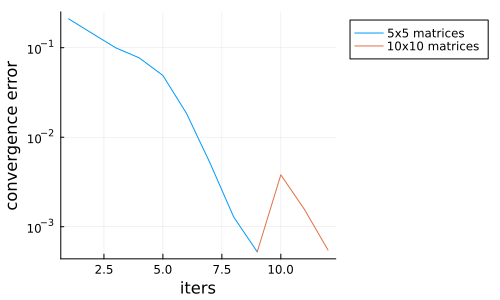

In [16]:
iters_cum = cumsum(iters)
inds = 1:iters_cum[1]
pl_iters = plot(inds, cb.Δs[inds], label="$(matrix_sizes[1])x$(matrix_sizes[1]) matrices")
for i in 2:length(iters)
    inds = iters_cum[i-1]:iters_cum[i]
   plot!(pl_iters, inds, cb.Δs[inds], label="$(matrix_sizes[i])x$(matrix_sizes[i]) matrices")
end
plot(pl_iters, ylabel="convergence error", xlabel="iters", yaxis=:log10, size=(500,300), legend=:outertopright)

In [17]:
spin(x, i) = 3-2x
m = mean(means(spin, bp));

In [21]:
sms = SoftMarginSampler(bp);

In [22]:
sample!(sms, 100)
spin(x) = 3-2x
m_mc = [vec(spin.(mean(X, dims=1))) for X in sms.X];

SoftMargin sampling 100%|████████████████████████████████| Time: 0:00:03


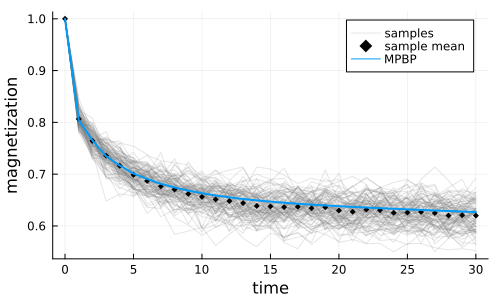

In [31]:
myblue = theme_palette(:auto)[1]
pl = plot(0:T, m_mc, label=permutedims(["samples"; fill("", length(m_mc)-1)]), c=:gray, la=0.2)
plot!(pl, 0:T, mean(m_mc), label="sample mean", c=:black, m=:diamond, ms=3, msc=:auto, st=:scatter)
plot!(pl, 0:T, m, lw=2, xlabel="time", ylabel="magnetization", msc=:auto, c=myblue,
    size=(500,300), xticks=0:5:T, ms=2, label="MPBP")

In [41]:
jldsave("plot_data/glauber_RFIM.jld2"; T, m_mc, m);